In [ ]:
!unzip data.zip

In [31]:
# ## 1. Setup and Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectFromModel

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, precision_recall_curve, auc

# 시각화 스타일 설정
plt.style.use('seaborn-v0_8-whitegrid')
# 경고 메시지 무시
import warnings
warnings.filterwarnings('ignore')

In [32]:
# ## 2. Data Loading and Initial Exploration
try:
    # 데이터 파일명이 다를 경우 수정해주세요.
    train_df = pd.read_csv("/content/data/train.csv")
    test_df = pd.read_csv("/content/data/test.csv")
    print("Train and Test datasets loaded successfully.")
    print(f"Train shape: {train_df.shape}, Test shape: {test_df.shape}")
except FileNotFoundError:
    print("Error: 'train.csv' or 'test.csv' not found. Please check file paths.")
    train_df = pd.DataFrame()

if not train_df.empty:
    # 불필요한 'ID' 컬럼 제거
    X = train_df.drop(['ID', 'TARGET'], axis=1)
    y = train_df['TARGET']
    X_test_final = test_df.drop('ID', axis=1) # 최종 제출용 테스트 데이터

    print("\nInitial feature count:", X.shape[1])

Train and Test datasets loaded successfully.
Train shape: (76020, 371), Test shape: (75818, 370)

Initial feature count: 369


Features remaining after VarianceThreshold: 272


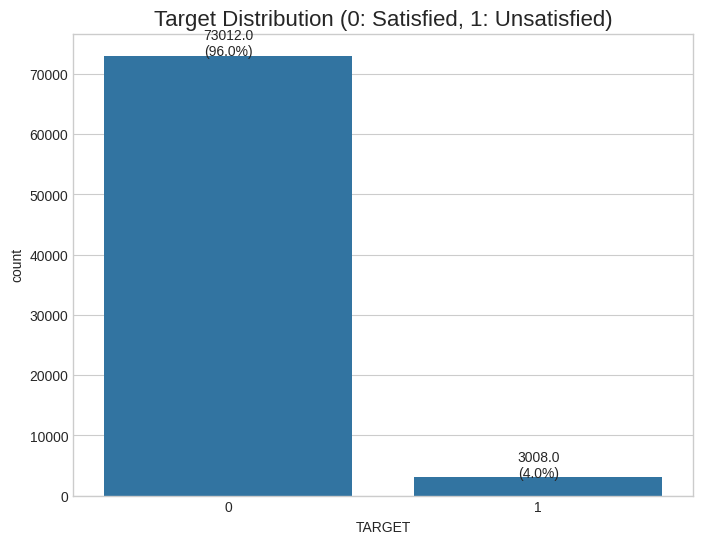

In [33]:
# ## 3. Feature Engineering and EDA
if not train_df.empty:
    # ### 3.1. Removing Constant and Quasi-Constant Features
    # 분산이 0.01 이하인, 거의 변화가 없는 특성 제거
    selector = VarianceThreshold(threshold=0.01)
    X = selector.fit_transform(X)
    X_test_final = selector.transform(X_test_final)
    print(f"Features remaining after VarianceThreshold: {X.shape[1]}")

    # ### 3.2. EDA: Class Imbalance
    plt.figure(figsize=(8, 6))
    ax = sns.countplot(x=y)
    plt.title('Target Distribution (0: Satisfied, 1: Unsatisfied)', fontsize=16)
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}\n({p.get_height()/len(y)*100:.1f}%)',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 9), textcoords='offset points')
    plt.show()

In [34]:
# ## 4. Data Splitting and Scaling
if not train_df.empty:
    # 훈련/검증 데이터 분할
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # 데이터 스케일링
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test_final_scaled = scaler.transform(X_test_final)

    print(f"\nTraining data shape: {X_train.shape}")
    print(f"Validation data shape: {X_val.shape}")


Training data shape: (60816, 272)
Validation data shape: (15204, 272)


In [35]:
# ## 5. Model Training and Comparison
if not train_df.empty:
    # 불균형 데이터 처리를 위한 가중치 계산
    scale_pos_weight = np.sqrt(y_train.value_counts()[0] / y_train.value_counts()[1])

    models = {
        "Logistic Regression": LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000),
        "Random Forest": RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1),
        "LightGBM": LGBMClassifier(random_state=42, scale_pos_weight=scale_pos_weight, n_jobs=-1)
    }

    results = {}

    for name, model in models.items():
        print(f"\n--- Training {name} ---")
        model.fit(X_train, y_train)
        y_pred_proba = model.predict_proba(X_val)[:, 1]

        roc_auc = roc_auc_score(y_val, y_pred_proba)

        results[name] = {'ROC AUC': roc_auc}
        print(f"ROC AUC on validation data: {roc_auc:.4f}")

    results_df = pd.DataFrame(results).T
    print("\n--- Model Performance Comparison ---")
    print(results_df.sort_values(by='ROC AUC', ascending=False))


--- Training Logistic Regression ---
ROC AUC on validation data: 0.8032

--- Training Random Forest ---
ROC AUC on validation data: 0.7501

--- Training LightGBM ---
[LightGBM] [Info] Number of positive: 2406, number of negative: 58410
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.080617 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14411
[LightGBM] [Info] Number of data points in the train set: 60816, number of used features: 224
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.039562 -> initscore=-3.189521
[LightGBM] [Info] Start training from score -3.189521
ROC AUC on validation data: 0.8483

--- Model Performance Comparison ---
                      ROC AUC
LightGBM             0.848312
Logistic Regression  0.803182
Random Forest        0.750119


In [36]:
# ## 6. Hyperparameter Tuning and Final Model
if not train_df.empty:
    print("\n--- Hyperparameter Tuning for LightGBM ---")

    lgbm = LGBMClassifier(random_state=42, scale_pos_weight=scale_pos_weight, n_jobs=-1)

    # 탐색할 파라미터 그리드
    param_grid = {
        'n_estimators': [100, 200, 500],
        'learning_rate': [0.01, 0.05, 0.1],
        'num_leaves': [31, 50, 70],
        'max_depth': [5, 7, 10],
        'colsample_bytree': [0.7, 0.8, 0.9],
        'subsample': [0.7, 0.8, 0.9]
    }

    # Stratified K-Fold 교차 검증
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    # RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=lgbm,
        param_distributions=param_grid,
        n_iter=10, # 10개 조합만 랜덤하게 테스트
        scoring='roc_auc',
        cv=skf,
        verbose=1,
        random_state=42
    )

    random_search.fit(X_train, y_train)
    print("\nBest parameters found: ", random_search.best_params_)

    # 최적 파라미터로 최종 모델 학습
    best_lgbm = random_search.best_estimator_


--- Hyperparameter Tuning for LightGBM ---
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[LightGBM] [Info] Number of positive: 1604, number of negative: 38940
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.056261 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13378
[LightGBM] [Info] Number of data points in the train set: 40544, number of used features: 217
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.039562 -> initscore=-3.189521
[LightGBM] [Info] Start training from score -3.189521
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1604, number of negative: 38940
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.157713 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, 


--- Detailed Analysis of Best Model: LightGBM (Tuned) ---


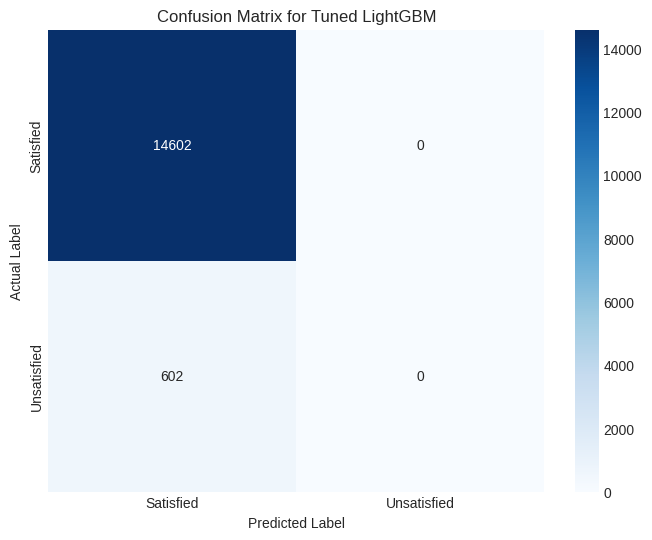


Classification Report
              precision    recall  f1-score   support

   Satisfied       0.96      1.00      0.98     14602
 Unsatisfied       0.00      0.00      0.00       602

    accuracy                           0.96     15204
   macro avg       0.48      0.50      0.49     15204
weighted avg       0.92      0.96      0.94     15204



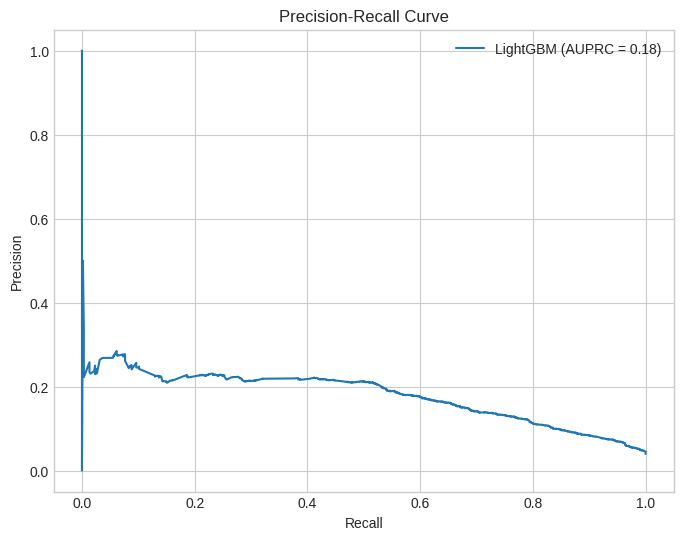

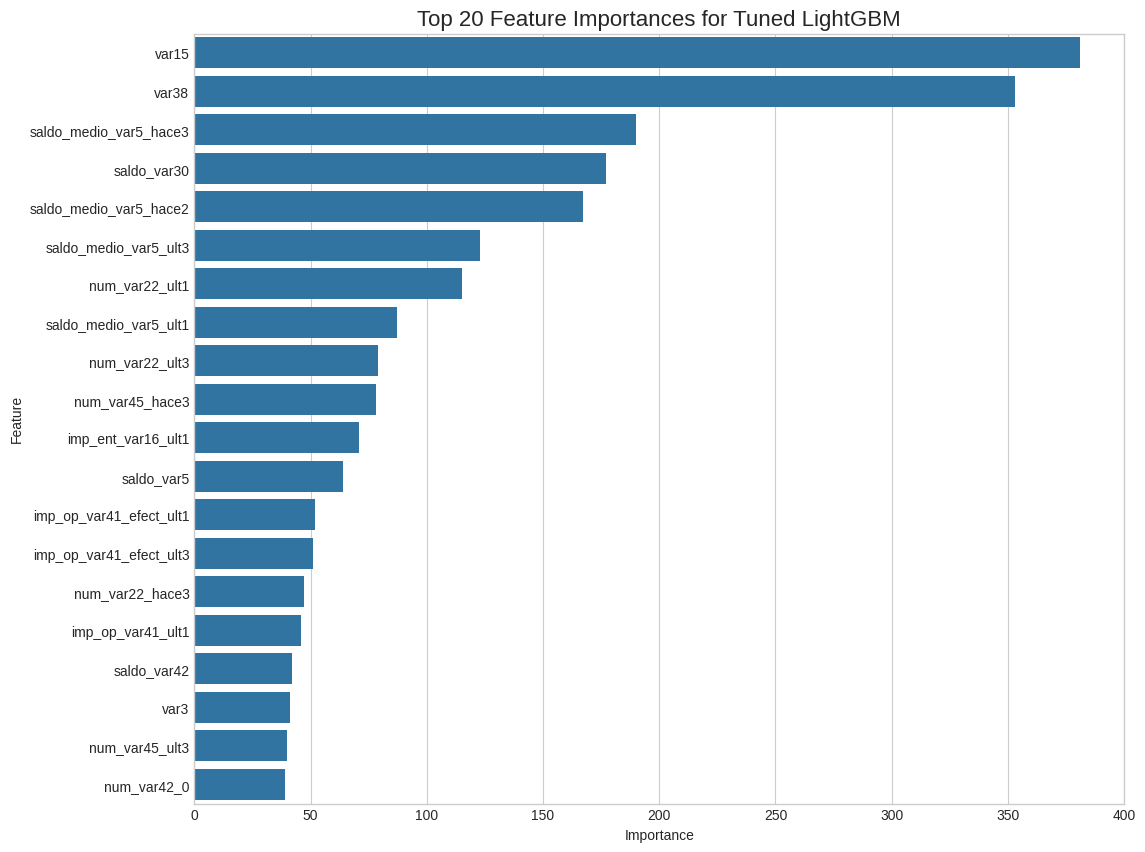

In [37]:
# ## 7. Final Evaluation and Analysis
if not train_df.empty:
    print(f"\n--- Detailed Analysis of Best Model: LightGBM (Tuned) ---")

    y_pred_best_proba = best_lgbm.predict_proba(X_val)[:, 1]
    y_pred_best = best_lgbm.predict(X_val)

    # Confusion Matrix
    cm = confusion_matrix(y_val, y_pred_best)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Satisfied', 'Unsatisfied'], yticklabels=['Satisfied', 'Unsatisfied'])
    plt.title('Confusion Matrix for Tuned LightGBM')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Classification Report
    print('\nClassification Report')
    print(classification_report(y_val, y_pred_best, target_names=['Satisfied', 'Unsatisfied']))

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_val, y_pred_best_proba)
    auprc = auc(recall, precision)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f'LightGBM (AUPRC = {auprc:.2f})')
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Feature Importance (원본 특성 이름 매핑)
    # VarianceThreshold를 통과한 특성들의 인덱스를 가져옴
    selected_indices = selector.get_support(indices=True)
    # 원본 특성 이름에서 선택된 특성들의 이름을 가져옴
    selected_feature_names = train_df.drop(['ID', 'TARGET'], axis=1).columns[selected_indices]

    importances = best_lgbm.feature_importances_
    feature_importance_df = pd.DataFrame({'Feature': selected_feature_names, 'Importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(12, 10))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20))
    plt.title('Top 20 Feature Importances for Tuned LightGBM', fontsize=16)
    plt.show()